In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from xgboost import XGBClassifier, plot_importance
import shap
from sklearn.manifold import TSNE
import os
import warnings
warnings.filterwarnings("ignore")


data_dir_for_modeling = '/home/tun62034/fuadhassan/nfl-data-bowl/Sample_Data/For_Modeling'

all_data = pd.read_parquet(os.path.join(data_dir_for_modeling, 'all_play.parquet'))
target = pd.read_parquet(os.path.join(data_dir_for_modeling, 'scoring_system.parquet'))
data = all_data.merge(target, on=['gameId', 'playId'], how='left')
data.fillna(0, inplace=True)

X = data.drop(columns=['gameId', 'playId', 'isConfusedPlay'])
y = data['isConfusedPlay']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=200, random_state=42)),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
])


param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [5, 10],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0],
}


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nBest Params:", search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


xgb_model = best_model.named_steps['xgb']
X_pca_test = best_model.named_steps['pca'].transform(
    best_model.named_steps['scaler'].transform(X_test)
)
# Best Params: {'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}

/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:59:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:59:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:00:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tun62034/fuadhassan/nfl-data-bowl/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


Best Params: {'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2924
           1       0.25      0.29      0.27       300

    accuracy                           0.85      3224
   macro avg       0.59      0.60      0.59      3224
weighted avg       0.86      0.85      0.86      3224

Confusion Matrix:
 [[2657  267]
 [ 213   87]]
ROC AUC Score: 0.6791495668034655


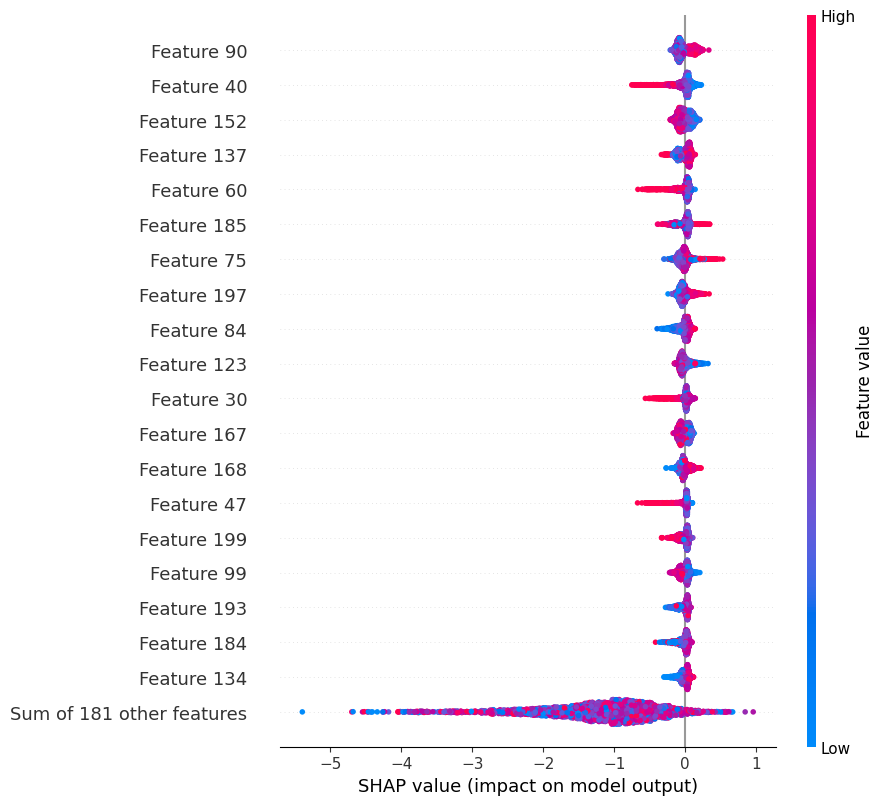

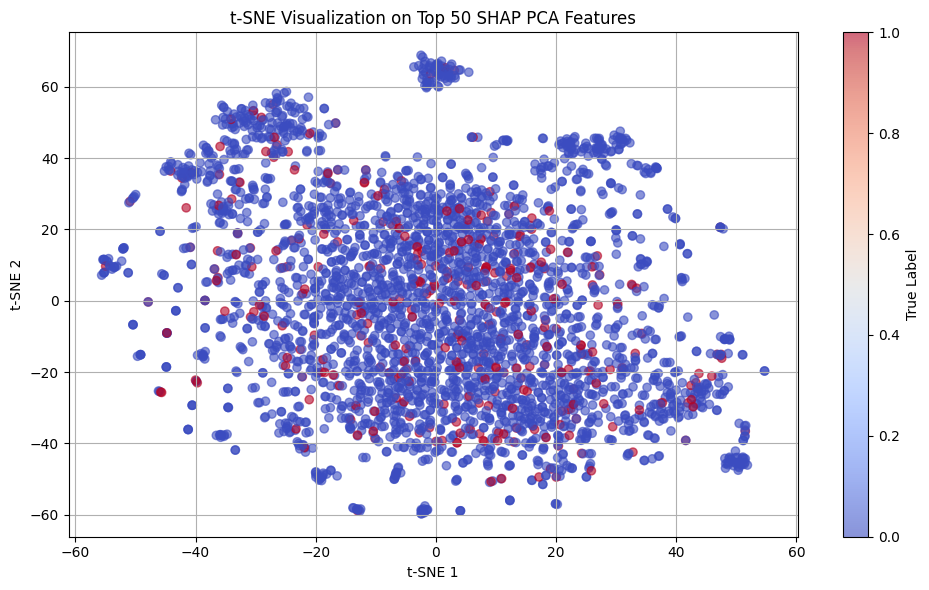

<Figure size 1000x600 with 0 Axes>

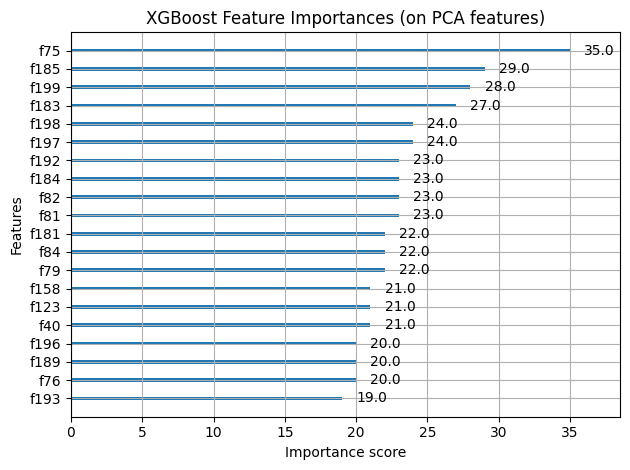

In [ ]:

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_pca_test)
shap.plots.beeswarm(shap_values, max_display=20)
shap_df = pd.DataFrame(shap_values.values, columns=[f"PCA{i+1}" for i in range(X_pca_test.shape[1])])
feature_importance = np.abs(shap_df).mean().sort_values(ascending=False)
top_pca_features = feature_importance.head(50).index
X_top50 = pd.DataFrame(X_pca_test, columns=shap_df.columns)[top_pca_features]
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_top50)


plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='True Label')
plt.title("t-SNE Visualization on Top 50 SHAP PCA Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=20)
plt.tight_layout()
plt.show()

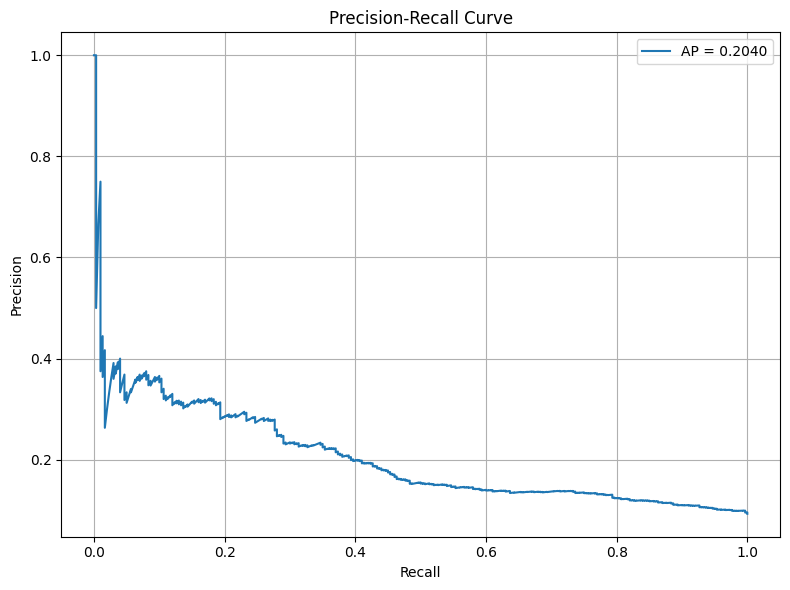


Balanced Accuracy Score: 0.5993


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, balanced_accuracy_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy Score: {bal_acc:.4f}")
